In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [3]:
def generar_particiones(filename, n, p_test):
    ds = np.genfromtxt(filename, delimiter=',')
    n_test = int(ds.shape[0] * p_test)
    n_train = ds.shape[0] - n_test
    M_test = np.zeros((n,n_test),dtype = int)
    M_train = np.zeros((n, n_train),dtype = int)

    for i in range(n):
        idx=np.random.choice(range(ds.shape[0]),ds.shape[0],replace = False)
        idx_test = idx[0:n_test]
        idx_train = idx[n_test:ds.shape[0]]
        M_test[i] = idx_test
        M_train[i] = idx_train
    
    return (ds, M_test, M_train)


# Ejercicio 3

Implemente el algoritmo de retropropagación para un perceptrón multicapa de forma que se puedan elegir libremente las cantidades de capas de la red y de neuronas en cada capa.

In [4]:
def sigmoidea(x):
    return np.divide(2, (1 + np.exp(-x))) - 1

In [5]:
class layer:
    def __init__(self, NNeurons, NInputs):
        # Almacenar la dimensión de entrada y cantidad de neuronas
        self.neurons_ = NNeurons
        self.inputs_ = NInputs

        # Inicializar la matriz de pesos de N x M con valores aleatorios
        # con una distribución normal centrada en 0 y norma < 0.5 aprox 
        self.w = np.random.normal(loc = 0, scale = 0.15, size = (NNeurons, NInputs))
        
    def eval(self, x):
        # Comprobar que la dimension de la entrada es igual a la incializada 
        assert x.shape[0] == self.inputs_, \
            f"La entrada de dimensión {x.shape[0]} no coincide con la declarada {self.inputs_}"

        # Producto interno entre la entrada y los pesos
        y = np.dot(self.w, x)
        
        # No linealidad
        z = sigmoidea(y)
        return z   


In [6]:
def MultiLayerPerceptron_init(neuronsPerLayer, NInputs):
    # La red estará representada como un arreglo de capas
    network = []
    
    # Auxiliar para definiar la cantidad de entradas de cada capa
    # La primera coincide con la entrada de la red
    NInputs_aux = NInputs

    # Para cada capa representada como el número de neuronas
    for layerNeurons in neuronsPerLayer:
        # Se crea una capa en base a la cantidad de salidas de la capa
        # anterior + 1 (el bias) y con el número de neuronas indicado
        network.append(layer(layerNeurons, NInputs_aux + 1))
        
        # Adelantar la cantidad de entradas para la próxima capa
        NInputs_aux = layerNeurons
        
    return(network)

In [7]:
# TODO: Agregar opción para que a la primer capa no le agregue el bias (entonces
# se lo agregamos nosotros al dataset todo de una)

# TODO: Que devuelva una tupla, que el primer elemento sea la salida de la red
# y el segundo sea todas las salidas intermedias

def MultiLayerPerceptron_forward(network, input):
    # La salida de cada capa será acumulada en un arreglo
    # que es devuelto para luego utilizar en la etapa de train
    y = [input]
    
    for i in range(len(network)): # Para cada capa en la red
        # Agregar el bias a la entrada de la capa i (como primer componente)
        x_ = np.hstack((-1, y[i]))

        # Calcular la salida de la capa i
        y_ = network[i].eval(x_)
        
        # Agregar la salida al arreglo, que será la entrada de la siguiente
        y.append(y_)

    return y

In [8]:
def MultiLayerPerceptron_backward(network, y, yd):
    # Se calcula el error entre la salida de la red (último componente de y)
    # y la salida deseada (la dimensión será la cantidad de neuronas a la salida)
    error_ = yd - y[-1]

    # Arreglo para almacenar el gradiente local instantaneo de cada capa
    grad = []

    # Calcular el gradiente de la capa de salida y guardarlo
    grad.append((np.multiply(error_, np.multiply((1 + y[-1]), (1 - y[-1])))) * 0.5)
    
    # Recorriendo las capas desde la penultima hacia la de entrada
    for i in range(len(network)-1,0,-1):
        # De la capa siguiente (en el orden forward), tomar la matriz de pesos
        # sin la columna de pesos asociados al bias, y transponerla (wT_)
        wT_ = network[i].w[:,1:].T

        # Calcular el gradiente local instantaneo como el producto interno entre
        # wT_ y el gradiente de error local de esa misma capa (la siguiente en orden forward)
        # en lo que se conoce como retropropagación del error
        # TODO: chequear el indexado
        d_ = np.dot(wT_, grad[len(network)-1-i])

        # Luego multiplicar por la derivada de la sigmoidea
        g_ = (np.multiply(d_, np.multiply((1 + y[i]), (1 - y[i])))) * 0.5
        
        # Agregar al arreglo de gradientes
        grad.append(g_)
        
    return grad


In [9]:
# TODO: Si el arreglo de gradientes está ordenado de atrás para adelante
# recorrerlo alrevés para que no te queden índices inversos

def MultiLayerPerceptron_update(network, y, grad, lr):
    # Actualización de pesos para cada capa
    for i in range(len(network)):
        # Se calcula el producto entre el gradiente local instantáneo de la capa 
        # con la entrada de la capa (con bias), esto multiplicado por la tasa
        # de aprendizaje resulta en la matriz de actualización de pesos
        Dw_ = lr * np.outer(grad[-(i+1)], np.hstack((-1, y[i])))
        
        # Los nuevos pesos se calculan como el Delta + los pesos "viejos"
        network[i].w += Dw_
        
    return network 

## Problema XOR
### Train

In [ ]:
ds, M_tst, M_trn  =  generar_particiones('icgtp1datos/XOR_trn.csv', 1, 0.2)

# Generar el vector de entradas para entrenamiento
X = ds[M_trn[0,:], :-1]
# Generar el vector de salida deseada para entrenamiento
Yd = ds[M_trn[0,:], -1]

In [ ]:
# Configuración de red para resolver XOR (2 rectas = 2 neuronas de entrada)
layerStack = np.array([2, 1])

# Crear la red en base a la dimensión de una entrada
network = MultiLayerPerceptron_init(layerStack, X.shape[1])

# Parámetros de entrenamiento
NEpoch = 40             # Cantidad de épocas máximas
errorThr = 0.01         # Umbral de error para finalizar
lr = 1E-2               # Tasa de aprendizaje

# Arreglos auxiliares para guardar la evolución del error de la red
errorRatePerEpoch = []
MMSEPerEpoch = []

for epoch in range(NEpoch): # Para cada época
    for pattern, yd in zip(X, Yd): # Para cada patrón en la partición
        # Calcular la salida según los pesos actuales (pasada hacia adelante)
        y_ = MultiLayerPerceptron_forward(network, pattern)
        #print(f'salida{i}={y}')

        # Realizar la propagación hacia atrás donde se calculan los gradientes
        # instantáneos (pasada hacia atrás)
        grad_ = MultiLayerPerceptron_backward(network, y_, yd)
        
        # Actualizar los pesos de la red
        network = MultiLayerPerceptron_update(network, y_, grad_, lr)
    
    # Para la validación se utilizarán todos los patrones y se calculará una
    # tasa de error, si esta es menor al umbral, se termina el proceso de entrenamiento
    # A la vez, se calculará el error cuadrático medio para tener una evolución
    # de dicha variable a lo largo de las épocas
    errorsAccum_ = 0    # Acumulador de errores
    SEAcumm_ = 0        # Acumulador error cuadrático
    for patron, yd in zip(X, Yd):
        # Evaluar el patron
        z_ = MultiLayerPerceptron_forward(network, patron)[-1]
        
        # Codificación de la salida en las 2 clases
        y_ = -1 if (z_ < 0) else 1
        
        # Comparación con la salida deseada y acumulación de errores
        errorsAccum_ += int(y_ != yd)

        # Cálculo del error cuadrático y acumulación
        SEAcumm_ += np.sum(np.square(yd - z_))

    # Tasa de error: errores / patrones evaluados
    errorRate_ = (errorsAccum_/X.shape[0])
    # Guardar la tasa de error de la época
    errorRatePerEpoch= np.append(errorRatePerEpoch, [errorRate_])
    
    # Calcular el error cuadrático medio promedio: MSE / patrones evaluados
    MSEMean_= (SEAcumm_/X.shape[0])
    # Guardar el error cuadrático medio promedio de la época
    MMSEPerEpoch = np.append(MMSEPerEpoch, MSEMean_)

    # Si la tasa de error es menor al umbral, termina el proceso de entrenamiento
    if (errorRate_ < errorThr):
        break

# Imprimir información acerca del entrenamiento
print(f'Finalizó en la época {epoch+1} con una tasa de error de {errorRatePerEpoch[-1]}')

Finalizó en la época 20 con una tasa de error de 0.0


### Plot

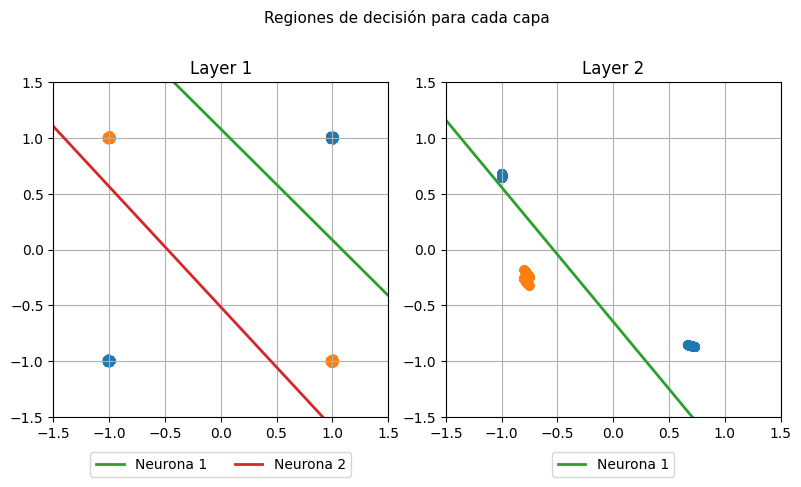

In [ ]:
# Separar los pesos de cada neurona
w11 = network[0].w[0]
w12 = network[0].w[1]
w21 = network[1].w[0]

# Clases de los patrones
X_x = X[:,0]
X_y = X[:,1]
colors_ = np.where(X_x > 0, np.where(X_y > 0, 'C0', 'C1'), np.where(X_y < 0, 'C0', 'C1'))

# Calcular la salida intermedia de la capa 1 y separar cada neurona
Y_network = [MultiLayerPerceptron_forward(network, x)[1] for x in X]
Y_L1_N1 = [i[0] for i in Y_network]
Y_L1_N2 = [i[1] for i in Y_network]

################################

# Setup subplots
fig1, (fig1_ax0, fig1_ax1) = plt.subplots(ncols = 2, figsize = (8,5), subplot_kw = dict(box_aspect = 1))
fig1.tight_layout()
fig1.suptitle('Regiones de decisión para cada capa',  fontsize = 11)

################################
# Layer 1
# Parameters config
fig1_ax0.autoscale(False)
fig1_ax0.set_xlim((-1.5, 1.5))
fig1_ax0.set_ylim((-1.5, 1.5))
# fig1_ax0.set_aspect('equal')
fig1_ax0.grid()
fig1_ax0.set_title("Layer 1")

# Patrones
fig1_ax0.scatter(X_x, X_y, c = colors_, s = 5, marker = '.')

xx = np.arange(-3, 3, 0.01)
# Recta para la neurona 1
a1 = w11[0] / w11[2]
b1 = w11[1] / w11[2]
fig1_ax0.plot(xx, a1 - b1 * xx, c='C2', linewidth=2, label = 'Neurona 1')
# Recta para la neurona 2
a2 = w12[0] / w12[2]
b2 = w12[1] / w12[2]
fig1_ax0.plot(xx, a2 - b2 * xx, c='C3', linewidth=2, label = 'Neurona 2')

fig1_ax0.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

################################
# Layer 1
# Parameters config
fig1_ax1.autoscale(False)
fig1_ax1.set_xlim((-1.5, 1.5))
fig1_ax1.set_ylim((-1.5, 1.5))
# fig1_ax1.set_aspect('equal')
fig1_ax1.grid()
fig1_ax1.set_title("Layer 2")

# Patrones proyectados en la capa 1
fig1_ax1.scatter(Y_L1_N1, Y_L1_N2, c = colors_)

xx = np.arange(-3, 3, 0.1)
# Recta para la neurona 1
a3 = w21[0] / w21[2]
b3 = w21[1] / w21[2]
fig1_ax1.plot(xx, a3 - b3 * xx, c='C2', linewidth=2, label = 'Neurona 1')

fig1_ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=1)

# plt.subplots_adjust(top=1.2)
plt.show()

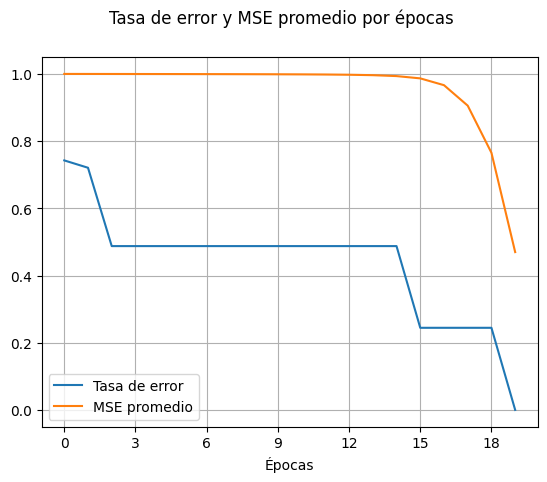

In [ ]:
# Gráfica de la tasa de error por época junto con el MSE promedio por época
epochs = errorRatePerEpoch.shape[0]
xx_ = range(epochs)

fig2, fig2_ax = plt.subplots()
fig2.suptitle("Tasa de error y MSE promedio por épocas")
fig2_ax.set_xlabel('Épocas')
fig2_ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Solo ticks en enteros
fig2_ax.grid()

fig2_ax.plot(xx_, errorRatePerEpoch, label='Tasa de error')
fig2_ax.plot(xx_, MMSEPerEpoch, label='MSE promedio')

fig2_ax.legend()

plt.show()

### Test

In [ ]:
# Generar el vector de entradas para test
XTest = ds[M_tst[0,:], :-1]
# Generar el vector de salida deseada para test
YdTest = ds[M_tst[0,:], -1]

errorsAccum_ = 0     # Acumulador de errores
for pattern, yd in zip(XTest, YdTest):
    # Calcular la salida
    z_ = MultiLayerPerceptron_forward(network, pattern)
    
    # Codificación de la salida
    y_ = -1 if (z_[-1] < 0) else 1
    
    # Comparación con la salida deseada y acumulación de errores
    errorsAccum_ += int(y_ != yd)

print(f'Tasa de error en prueba {errorsAccum_ / XTest.shape[0]}')

Tasa de error en prueba 0.0
